## Importando bibliotecas

In [ ]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import classification_report

## Modelo de ML


Ler o Arquivo CSV

In [ ]:
df = pd.read_csv('review_clientes_melhores_compras.csv')
df = df.drop('review_id', axis=1)

Separar os dados entre treino e teste, com as respectivas respostas

In [ ]:
split = round(len(df)*0.8)
train_reviews = df['review_cliente'][:split]
train_label = df['sentimento'][:split]
test_reviews = df['review_cliente'][split:]
test_label = df['sentimento'][split:]

Dividir os dados em apenas duas variáveis no formato adequado do TensorFlow

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_reviews, train_label))
test_dataset = tf.data.Dataset.from_tensor_slices((test_reviews, test_label))

Definindo o tamanho dos parâmetros.

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
VOCAB_SIZE=1000



Dividindo e embaralhando os dados.

In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Realizando o pre-processamento

In [ ]:
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

Criando o modelo

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Compilando o modelo

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

Treinando o modelo

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset, 
                    validation_steps=30)

Epoch 1/10
537/537 [==============================] - 45s 65ms/step - loss: 0.4456 - accuracy: 0.7182 - val_loss: 0.3160 - val_accuracy: 0.8906
Epoch 2/10
537/537 [==============================] - 33s 62ms/step - loss: 0.2838 - accuracy: 0.8937 - val_loss: 0.2816 - val_accuracy: 0.8922
Epoch 3/10
537/537 [==============================] - 34s 63ms/step - loss: 0.2625 - accuracy: 0.9003 - val_loss: 0.2689 - val_accuracy: 0.8969
Epoch 4/10
537/537 [==============================] - 32s 60ms/step - loss: 0.2538 - accuracy: 0.9058 - val_loss: 0.2635 - val_accuracy: 0.8974
Epoch 5/10
537/537 [==============================] - 32s 60ms/step - loss: 0.2489 - accuracy: 0.9089 - val_loss: 0.2614 - val_accuracy: 0.8979
Epoch 6/10
537/537 [==============================] - 32s 60ms/step - loss: 0.2457 - accuracy: 0.9094 - val_loss: 0.2600 - val_accuracy: 0.8958
Epoch 7/10
537/537 [==============================] - 32s 60ms/step - loss: 0.2434 - accuracy: 0.9102 - val_loss: 0.2599 - val_accuracy:

Validando o modelo

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

135/135 [==============================] - 2s 16ms/step - loss: 0.2645 - accuracy: 0.8981
Test Loss: 0.2644779682159424
Test Accuracy: 0.8981114625930786


Utilizando o modelo em uma amostra de texto

In [ ]:
sample_text = ('Interessante, preço amigável')
predictions = model.predict(np.array([sample_text]))
print(predictions)

[[1.1016219]]


In [ ]:
index=np.random.randint(1,1000)
user_review=df.review_cliente.loc[index]
print(user_review)
if (model.predict(np.array([user_review]))>0.5).astype("int32"):
  print("Sentimento positivo")
else:
  print("Sentimento negativo")

bom imaginar maior boneca legal
Sentimento positivo


Adicionando os resultados de sentimento pelo modelo em uma lista (0 e 1)

In [ ]:
test_pred = []
for attr, value in test_reviews.items():
        prediction = model.predict(np.array([value]))
        if (prediction > 0.5).astype("int32"):
          test_pred.append(1)
        else:
          test_pred.append(0)

In [ ]:
test_labels1 = test_label.tolist()

Plotando os gráficos de perda e acurácia do modelo

<Figure size 432x288 with 0 Axes>

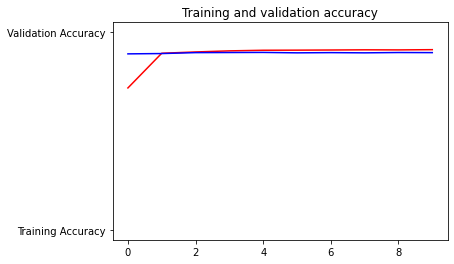

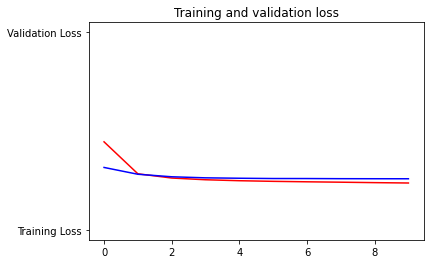

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs=range(len(acc))
plt.plot(epochs, acc, 'r', 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', 'Validation Accuracy')
plt.title('Training and validation accuracy')
plt.figure()
plt.plot(epochs, loss, 'r', 'Training Loss')
plt.plot(epochs, val_loss, 'b', 'Validation Loss')
plt.title('Training and validation loss')
plt.figure()

Fazendo a matriz de confusão

In [ ]:
confusion_matrix(test_labels1, test_pred)

array([[2602,  348],
       [ 526, 5102]])

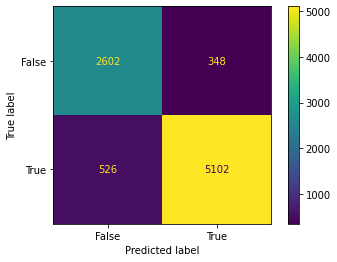

In [ ]:
confusion_matrix = metrics.confusion_matrix(test_labels1, test_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

Fazendo o score de precisão

In [ ]:
precision_score(test_labels1, test_pred)

0.9361467889908257

Fazendo o score do recall

In [ ]:
from sklearn.metrics import recall_score
recall_score(test_labels1, test_pred)

0.9065387348969438

Fazendo a curva ROC

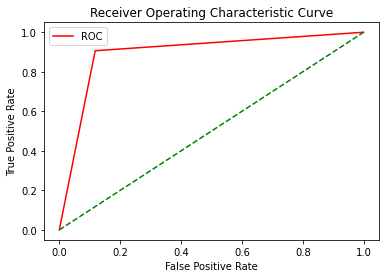

auc:  0.8942863166010142


In [ ]:
# função auxiliar para plotar o grafico da curva ROC
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()
    
# cria dois array de teste
# y= y de teste verdadeiros
# score = y probabilidade predita da classe
y = np.array(test_labels1)
scores = np.array(test_pred)
# calcula curva ROC 
fper, tper, thresholds = roc_curve(y, scores, pos_label=1)
# Plota o gráfico 
plot_roc_curve(fper, tper)
# Cálcula AUC - area under the ROC curve
auc = roc_auc_score(y, scores)
print("auc: ",auc)
### auc: 0.9639

In [ ]:
report = classification_report(test_labels1, test_pred)

In [ ]:
print(report)

              precision    recall  f1-score   support

           0       0.83      0.88      0.86      2950
           1       0.94      0.91      0.92      5628

    accuracy                           0.90      8578
   macro avg       0.88      0.89      0.89      8578
weighted avg       0.90      0.90      0.90      8578

